In [51]:
import pandas as pd
import numpy as np
import itertools
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from tqdm import tqdm_notebook as tqdm
import _pickle as pickle
plt.style.use('ggplot')

In [52]:
from google.colab import files
data_to_load = files.upload()

Saving BTC-USD.csv to BTC-USD (1).csv


In [53]:
import io
df = pd.read_csv(io.BytesIO(data_to_load['BTC-USD.csv']))

In [54]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-10-14,11429.047852,11539.977539,11307.831055,11429.506836,11429.506836,24103426719
1,2020-10-15,11426.602539,11569.914063,11303.603516,11495.349609,11495.349609,24487233058
2,2020-10-16,11502.828125,11540.061523,11223.012695,11322.123047,11322.123047,25635480772
3,2020-10-17,11322.123047,11386.261719,11285.345703,11358.101563,11358.101563,19130430174
4,2020-10-18,11355.982422,11483.359375,11347.578125,11483.359375,11483.359375,18283314340
...,...,...,...,...,...,...,...
359,2021-10-08,53802.144531,55922.980469,53688.054688,53967.847656,53967.847656,34800873924
360,2021-10-09,53929.781250,55397.945313,53735.144531,54968.222656,54968.222656,32491211414
361,2021-10-10,54952.820313,56401.304688,54264.257813,54771.578125,54771.578125,39527792364
362,2021-10-11,54734.125000,57793.039063,54519.765625,57484.789063,57484.789063,42637331698


In [55]:
df['Date'] = pd.to_datetime(df.Date)
df.dtypes

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object

In [56]:
df.set_index('Date', inplace=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-10-14,11429.047852,11539.977539,11307.831055,11429.506836,11429.506836,24103426719
2020-10-15,11426.602539,11569.914063,11303.603516,11495.349609,11495.349609,24487233058
2020-10-16,11502.828125,11540.061523,11223.012695,11322.123047,11322.123047,25635480772
2020-10-17,11322.123047,11386.261719,11285.345703,11358.101563,11358.101563,19130430174
2020-10-18,11355.982422,11483.359375,11347.578125,11483.359375,11483.359375,18283314340


In [84]:
df = df[['Close']].loc['2020-10-14':]
df.head()

,Close
Date,
2020-10-14,11429.506836
2020-10-15,11495.349609
2020-10-16,11322.123047
2020-10-17,11358.101563
2020-10-18,11483.359375


In [85]:
with open("curr_bitcoin.pickle", 'wb') as fp:
    pickle.dump(df, fp)

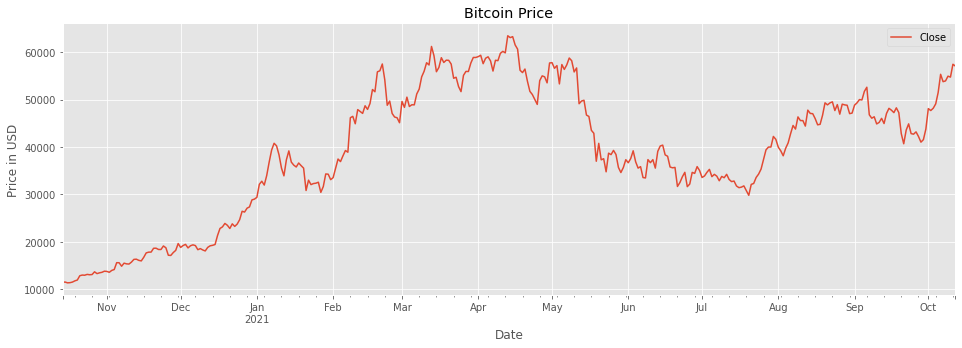

In [86]:
df.plot(figsize=(16,5))

plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.title('Bitcoin Price')
plt.savefig('btcprice.png')
plt.show()

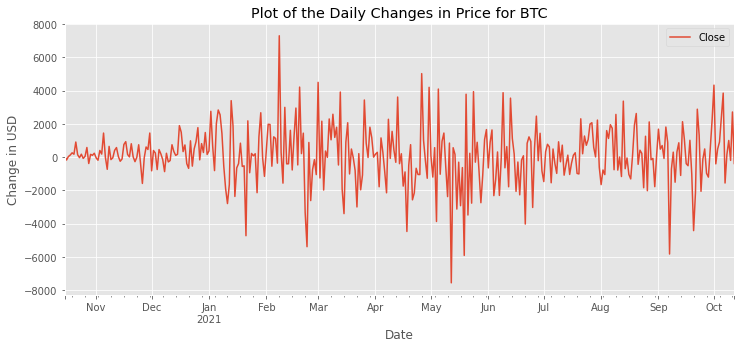

In [87]:
# Differencing the price
df_diff = df.diff(1).dropna()

# Plotting the differences daily
df_diff.plot(figsize=(12,5))
plt.title('Plot of the Daily Changes in Price for BTC')
plt.ylabel('Change in USD')
plt.show()

In [88]:
results = adfuller(df_diff.Close)
print(f"P-value: {results[1]}")

P-value: 0.0


In [89]:
# Converting the data to a logarithmic scale
df_log = pd.DataFrame(np.log(df.Close))

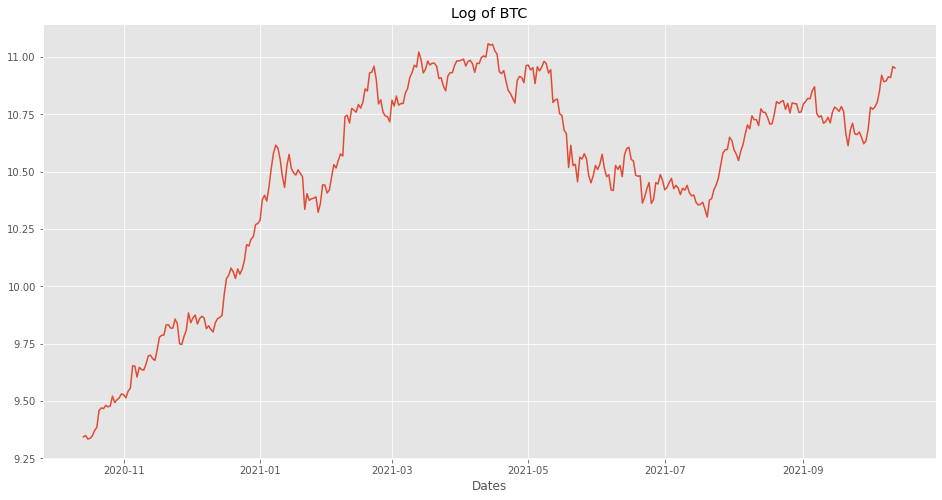

In [90]:
# Plotting the log of the data
plt.figure(figsize=(16,8))
plt.plot(df_log)

plt.title('Log of BTC')
plt.xlabel('Dates')

plt.savefig('btc_log.png')
plt.show()

In [91]:
# Differencing the log values
log_diff = df_log.diff().dropna()

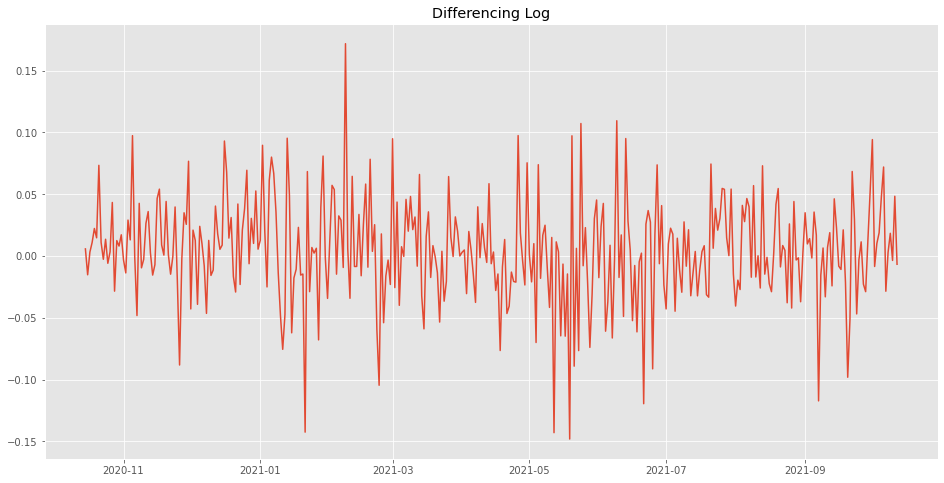

In [92]:
# Plotting the daily log difference
plt.figure(figsize=(16,8))
plt.plot(log_diff)
plt.title('Differencing Log')
plt.savefig('logdiff.png')
plt.show()

In [93]:
results = adfuller(log_diff.Close)
print(f"P-value: {results[1]}")

P-value: 0.0


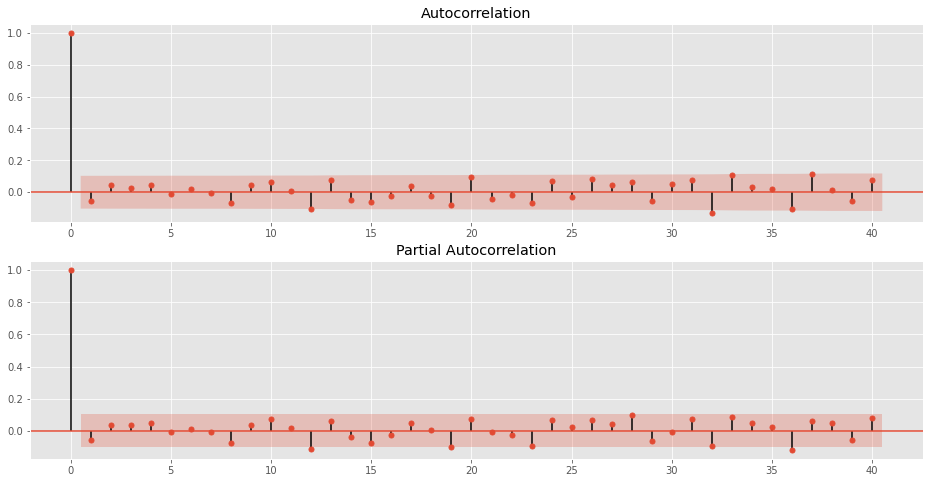

In [94]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(16,8))
plot_acf(df_diff, ax=ax1, lags=40)
plot_pacf(df_diff, ax=ax2, lags=40)
plt.show()

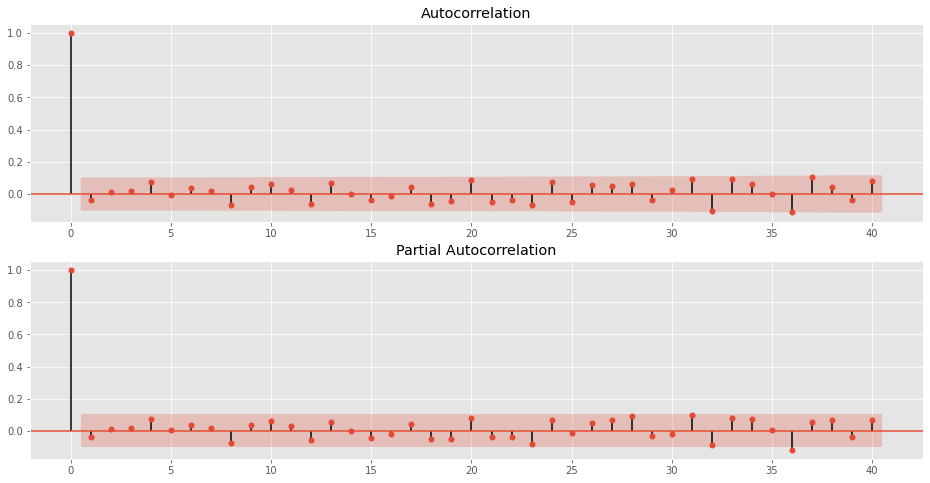

In [95]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(16,8))
plot_acf(log_diff, ax=ax1, lags=40)
plot_pacf(log_diff, ax=ax2, lags=40)
plt.savefig('acfpacf.png')
plt.show()

In [96]:
def best_param(model, data, pdq, pdqs):
    """
    Loops through each possible combo for pdq and pdqs
    Runs the model for each combo
    Retrieves the model with lowest AIC score
    """
    ans = []
    for comb in tqdm(pdq):
        for combs in tqdm(pdqs):
            try:
                mod = model(data,
                            order=comb,
                            seasonal_order=combs,
                            enforce_stationarity=False,
                            enforce_invertibility=False,
                            freq='D')

                output = mod.fit()
                ans.append([comb, combs, output.aic])
            except:
                continue

    ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
    return ans_df.loc[ans_df.aic.idxmin()]

In [97]:
# Assigning variables for p, d, q.
p = d = q = range(0,6)
d = range(2)

# Creating a list of all possible combinations of p, d, and q.
pdq = list(itertools.product(p, d, q))

# Keeping seasonality at zeroes
pdqs = [(0,0,0,0)]

In [98]:
# Finding the best parameters
best_param(SARIMAX, df_log, pdq, pdqs)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/72 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


pdq        (1, 0, 0)
pdqs    (0, 0, 0, 0)
aic         -1264.54
Name: 12, dtype: object

In [99]:
# pdq        (1, 0, 0)
# pdqs    (0, 0, 0, 0)
# aic         -1264.54

In [100]:
# Splitting 80/20
index = round(len(df)*.80)

train = df_log.iloc[:index]
test = df_log.iloc[index:]

In [101]:
# Fitting the model to the training set
model = SARIMAX(train, 
                order=(1, 0, 0), 
                seasonal_order=(0,0,0,0), 
                freq='D', 
                enforce_stationarity=False, 
                enforce_invertibility=False)
output = model.fit()

                           Statespace Model Results                           
Dep. Variable:                  Close   No. Observations:                  291
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 498.283
Date:                Wed, 13 Oct 2021   AIC                           -992.565
Time:                        13:11:35   BIC                           -985.225
Sample:                    10-14-2020   HQIC                          -989.625
                         - 07-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0004      0.000   4111.770      0.000       1.000       1.001
sigma2         0.0019      0.000     15.950      0.000       0.002       0.002
Ljung-Box (Q):                       60.20   Jarque-

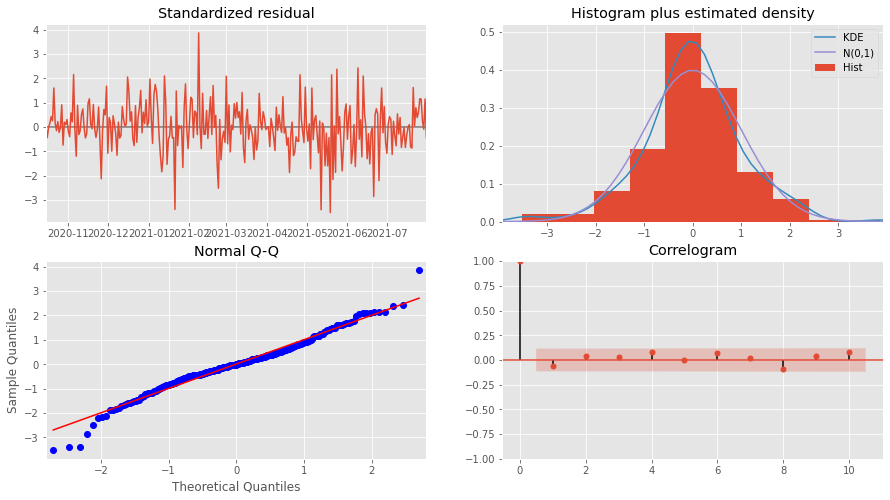

In [102]:
print(output.summary())
output.plot_diagnostics(figsize=(15,8))
plt.show()

In [103]:
# Values to test against the test set
fc   = output.get_forecast(len(test))
conf = fc.conf_int()

# Transforming the values back to normal
fc_series    = np.exp(pd.Series(fc.predicted_mean, index=test.index))
lower_series = np.exp(pd.Series(conf.iloc[:, 0], index=test.index))
upper_series = np.exp(pd.Series(conf.iloc[:, 1], index=test.index))

etrain = np.exp(train)
etest  = np.exp(test)

# Values to test against the train set, see how the model fits
predictions = output.get_prediction(start=pd.to_datetime('2021'), dynamic=False)
pred        = np.exp(predictions.predicted_mean)

# Confidence interval for the training set
conf_int   = np.exp(predictions.conf_int())
low_conf   = np.exp(pd.Series(conf_int.iloc[:,0], index=train.index))
upper_conf = np.exp(pd.Series(conf_int.iloc[:,1], index=train.index))

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


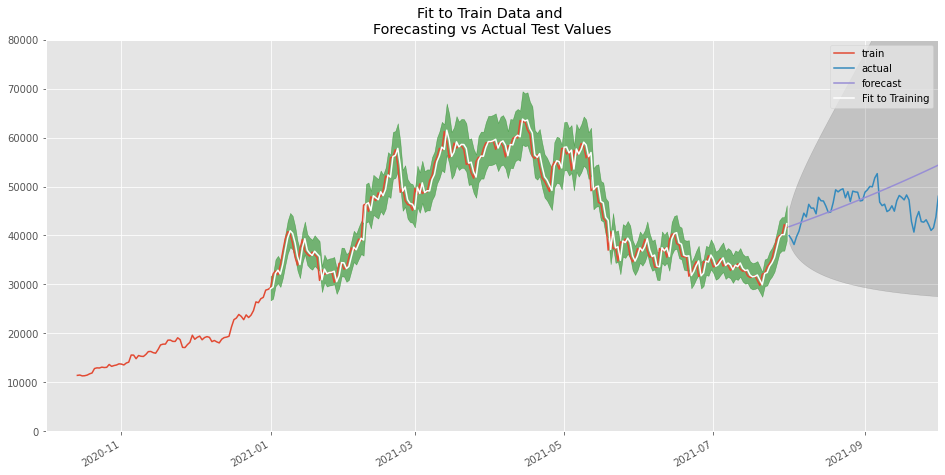

In [110]:
rcParams['figure.figsize'] = 16, 8

# Plotting the training set, test set,forecast, and confidence interval.
plt.plot(etrain, label='train')
plt.plot(etest, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)

# Plotting against the training data
pred.plot(label='Fit to Training', color='w')

# Confidence interval for the fitted data
plt.fill_between(conf_int.index, conf_int.iloc[:,0], conf_int.iloc[:,1], color='g',alpha=.5)

# Limiting the viewing size
plt.xlim(['2020-10', '2021-10'])
plt.ylim([0, 80000])

plt.title('Fit to Train Data and \nForecasting vs Actual Test Values')
plt.legend()
plt.savefig('btc_fit_fc.png')
plt.show()

In [105]:
forecast = pred
actual_val = etrain.Close

# Calculating our errors
rmse = np.sqrt(((forecast - actual_val) ** 2).mean())

print("The Root Mean Squared Error: ", rmse)

The Root Mean Squared Error:  2012.8438997100684


In [106]:
model = SARIMAX(df_log, 
                order=(1, 0, 0), 
                seasonal_order=(0,0,0,0), 
                freq='D', 
                enforce_stationarity=False, 
                enforce_invertibility=False)
output = model.fit()

In [107]:
# Getting the forecast of future values
future = output.get_forecast(steps=30)

# Transforming values back
pred_fut = np.exp(future.predicted_mean)

# Confidence interval for our forecasted values
pred_conf = future.conf_int()

# Transforming value back
pred_conf = np.exp(pred_conf)

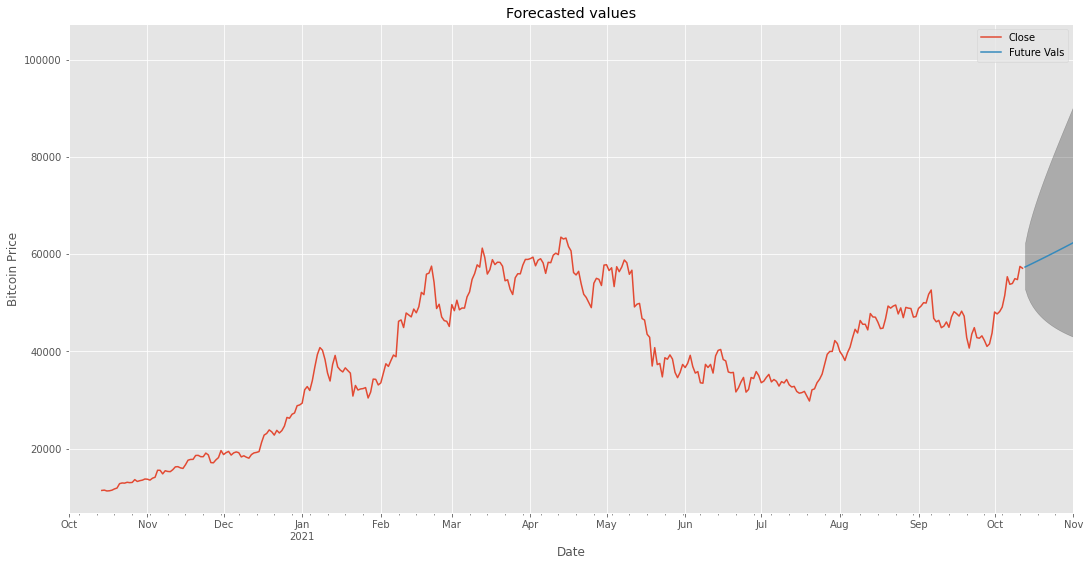

In [113]:
# Plotting the prices up to the most recent
ax = np.exp(df_log).plot(label='Actual', figsize=(18,9))

# Plottting the forecast
pred_fut.plot(ax=ax, label='Future Vals')

# Shading in the confidence interval
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=.25)

ax.set_xlabel('Date')
ax.set_ylabel('Bitcoin Price')
ax.set_xlim(['2020-10', '2021-11'])

plt.title('Forecasted values')
plt.legend()
plt.savefig('fc_val.png')
plt.show()

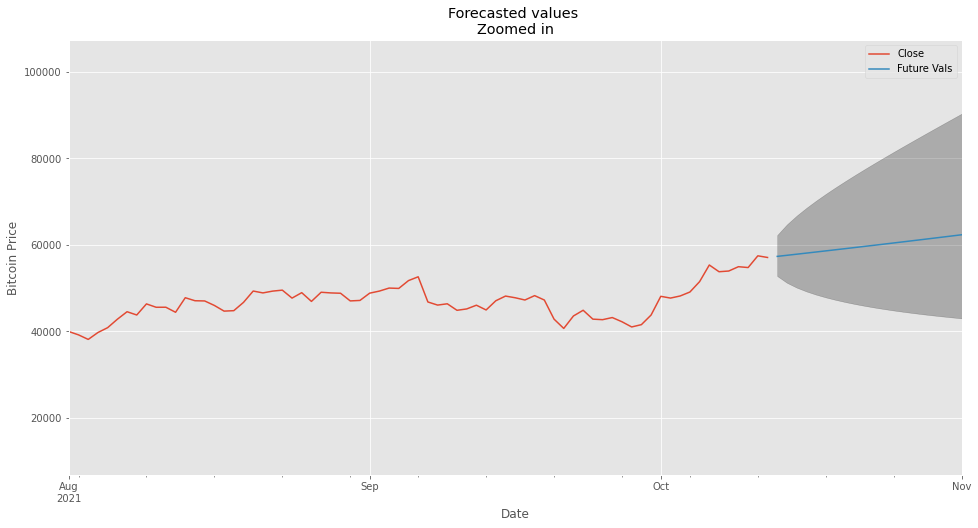

In [114]:
ax = np.exp(df_log).plot(label='Actual', figsize=(16,8))
pred_fut.plot(ax=ax, label='Future Vals')

ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=.25)

ax.set_xlabel('Date')
ax.set_ylabel('Bitcoin Price')
ax.set_xlim(['2021-08','2021-11'])

plt.title('Forecasted values \nZoomed in')
plt.legend()
plt.savefig('fc_zoom.png')
plt.show()